# Data Wrangling Final Project: Purple Air

**Purple Air**

PurpleAir sensors employ a dual laser counter to provide some level of data integrity. This is intended to provide a way of determining sensor health and fault detection. Some examples of what can go wrong with a laser counter are a fan failure, insects or other debris inside the device or just a layer of dust from long term exposure. If both laser counters (channels) are in agreement, the data can be seen as excellent quality. If there are different readings from the two channels, there may be a fault with one or both.In the case of a fault, the channel may be marked as flagged or downgraded (suspect or known faulty).

Two API Variants:
1. JSON Legacy
2. JSON Experimental
3. (Private sensors are not querried. Can ask for permission if you want!)

## Data Collection:

In [76]:
#Libaries
#Use the lab_basic venv

#Basics:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

#Scraping:
import requests
import json
from urllib.request import urlopen,urlretrieve
import sys
from datetime import datetime
import pytz


#Prediction
from fbprophet import Prophet
import statsmodels.formula.api as smf
import statsmodels.api as sm

#Geography
import geopandas as gpd
import fiona
from shapely.geometry import Point
import descartes
import contextily as ctx #Basemaps 

# Collect Data

### PurpleAir Data

Data collection for purpleair data is being run through their json querry and an airflow scheduling assistant. Essentially, purpleair only posts realtime data from their sensors to the web at an unknown refresh rate. There is no way to querry data from the past. Instead, one must manually collect scrape the data at some frequency for analysis.

To this end, I've put together an airflow DAG to collect this data, arange it into a pandas dataframe and pickle it for further use. This data would be best put into a SQL database. To ensure this project maintained a manageabler workload, I decided to take on only one new technology (airflow). Further down the road, I would like to create automate the datastream into a database to minimize footprint. 

To see the DAG file, please look at the .py file contained within this folder. 

All data is saved as either legacy/experimental _MONTH_DAY_HOUR_MIN .pkl

**Let's look at a subsample of the data**

In [3]:
directory = '/home/boogie2/external/tiny_tower_2/purpleair_data/'
data_direct = []

#Create a directory of the data
for filename in os.listdir(directory):
    
    #append the path to the list
    data_direct.append(os.path.join(directory, filename))
    
    #sort the data
    data_direct = sorted(data_direct)

In [4]:
print('There are currently {0} entries in the data folder'.format(len(data_direct)))

There are currently 265 entries in the data folder


In [24]:
#Check the data
print(data_direct[-2])
print(data_direct[131])

/home/boogie2/external/tiny_tower_2/purpleair_data/legacy_04_12_16_00.pkl
/home/boogie2/external/tiny_tower_2/purpleair_data/experimental_04_12_16_00.pkl


In [25]:
#Let's open a legacy test file
leg_test = pd.read_pickle(data_direct[-2])
leg_test.head()

,mapVersion,baseVersion,mapVersionString,ID,Label,DEVICE_LOCATIONTYPE,THINGSPEAK_PRIMARY_ID,THINGSPEAK_PRIMARY_ID_READ_KEY,THINGSPEAK_SECONDARY_ID,THINGSPEAK_SECONDARY_ID_READ_KEY,...,humidity,temp_f,pressure,AGE,Stats,ParentID,Flag,A_H,Voc,Ozone1
0,0.4,7,,14633,Hazelwood canary,outside,559921,CU4BQZZ38WO5UJ4C,559922,D0YNZ1LM59LL49VQ,...,31,81,1009.63,1,"{""v"":5.31,""v1"":4.81,""v2"":4.39,""v3"":3.51,""v4"":3...",NaN,NaN,NaN,NaN,NaN
1,0.4,7,,14634,Hazelwood canary B,NaN,559923,DULWDNCI9M6PCIPC,559924,EY2CNMYRUZHDW1AL,...,NaN,NaN,NaN,1,"{""v"":2.84,""v1"":2.05,""v2"":1.89,""v3"":1.47,""v4"":1...",14633.0,1.0,NaN,NaN,NaN
2,0.4,7,,25999,Villages of Bridgestone AQI,outside,694803,OO5PFS7JTQQSHQHE,694804,LW93B1YLLZ4N4QFM,...,27,93,997.47,0,"{""v"":12.37,""v1"":6.12,""v2"":8.5,""v3"":15.78,""v4"":...",NaN,1.0,NaN,NaN,NaN
3,0.4,7,,26000,Villages of Bridgestone AQI B,NaN,694805,OAPUW1RM0X9CJDYO,694806,XAFZ75MBJ90SZIU7,...,NaN,NaN,NaN,0,"{""v"":8.96,""v1"":5.45,""v2"":7.96,""v3"":15.02,""v4"":...",25999.0,NaN,NaN,NaN,NaN
4,0.4,7,,601,#1,NaN,195168,49V50OO5MTDR7UF6,195169,K07Z3AOWUMDGRTFD,...,32,84,1018.31,1,"{""v"":58.62,""v1"":46.73,""v2"":42.29,""v3"":36.71,""v...",NaN,NaN,NaN,NaN,NaN


In [26]:
#Let's open a experimental data file
exp_test = pd.read_pickle(data_direct[13])
exp_test.head()

,ID,pm,age,pm_0,pm_1,pm_2,pm_3,pm_4,pm_5,pm_6,...,Lon,Icon,isOwner,Flags,Voc,Ozone1,Adc,CH,version,count
0,20,1.0,1,1.0,0.9,0.8,0.7,0.6,0.7,1.3,...,-111.836120,0,0,0,NaN,NaN,0.01,1,7.0.4,7254
1,47,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-111.882600,0,0,0,NaN,1.83,1.83,0,7.0.4,7254
2,53,1.0,0,1.0,1.1,1.5,3.1,13.4,13.5,9.3,...,-111.704800,0,0,0,NaN,NaN,0.00,1,7.0.4,7254
3,72,18.2,0,18.2,18.6,19.0,19.5,21.3,22.9,25.5,...,-111.947075,0,0,0,NaN,NaN,0.05,1,7.0.4,7254
4,77,4.1,0,4.1,4.3,4.4,4.3,4.6,5.1,6.3,...,-111.825290,0,0,0,NaN,NaN,0.01,1,7.0.4,7254


**Conclusion**
The data collection appears to be working. Consistent recordings start at 04/07/20 @ 5:00 AM (MST)

### EPA Airnow sensors

These sensors are acting as ground truth as the purpleair-sensors are known to have quality control issues. Data is querried from the Airnow API and saved as .csv file.

For more detail: https://docs.airnowapi.org/Data/docs#sampleUsage


In [94]:
#Collect the information
def main():
    # API parameters
    options = {}
    options["url"] = "https://www.airnowapi.org/aq/data/"
    options["start_date"] = "2020-04-07"
    options["start_hour_utc"] = "06"
    options['end_date'] = '2020-04-12' #This for all the data through 11 in MST
    options['end_hour_utc'] = "05"
    options["parameters"] = "OZONE,PM25,PM10"
    options["bbox"] = "-113.989989,37.043937,-108.936278,41.989859" #minx,miny,maxx,maxy for state of utah (includes wyoming corner)
    options["data_type"] = "B"
    options["format"] = "text/csv"
    options["api_key"] = "0ABAAB64-E208-4B1A-B6D7-735E98877CE0"

    # API request URL
    REQUEST_URL = options["url"] \
                  + "?startDate=" + options["start_date"] \
                  + "T"+options['start_hour_utc']\
                  + "&endDate=" + options["end_date"] \
                  + "T"+options['end_hour_utc']\
                  + "&parameters=" + options["parameters"] \
                  + "&BBOX=" + options["bbox"] \
                  + "&datatype=" + options["data_type"] \
                  + "&format=" + options["format"] \
                  + "&verbose=1" \
                  + "&API_KEY=" + options["api_key"]

    try:
        # Request AirNowAPI data
        print("Requesting AirNowAPI data...")

        # User's home directory.
        download_file_name = "AirNowAPI" + datetime.now().strftime("_%Y%M%d%H%M%S.csv")
        download_file = os.path.join('/home/boogie2/Data_Science/Purp_Air_Analysis', download_file_name)
        
        print(REQUEST_URL)
        # Perform the AirNow API data request

        
        urlretrieve(REQUEST_URL, download_file)

    except Exception as e:
        print("Unable perform AirNowAPI request")
        sys.exit(1)

#Execute Data Collection
if __name__ == "__main__":
    main()
    

Requesting AirNowAPI data...
https://www.airnowapi.org/aq/data/?startDate=2020-04-07T06&endDate=2020-04-12T05&parameters=OZONE,PM25,PM10&BBOX=-113.989989,37.043937,-108.936278,41.989859&datatype=B&format=text/csv&verbose=1&API_KEY=0ABAAB64-E208-4B1A-B6D7-735E98877CE0


In [102]:
column_names = ['Latitude',
           'Longitude',
          'Time',
          'Parameter',
          'Concentration',
          'Unit',
          'Raw_Concentration',
          'AQI',
          'Category',
          'Site_Name',
          'Site_Agency',
          'AQS_ID',
          'FULL_AQS_ID']

airnow_2019_df = pd.read_csv('EPA2019_07_14.csv',header = None,names = column_names)
airnow_df = pd.read_csv('EPA2020_07_11.csv',header = None,names = column_names)

In [14]:
airnow_df.head()

,Latitude,Longitude,Time,Parameter,Concentration,Unit,Raw_Concentration,AQI,Category,Site_Name,Site_Agency,AQS_ID,FULL_AQS_ID
0,37.179000,-113.305200,2020-04-07T06:00,OZONE,33.0,PPB,31,1,Hurricane,Utah Department of Environmental Quality,490530007,840490530007,NaN
1,37.179000,-113.305200,2020-04-07T06:00,PM2.5,4.2,UG/M3,18,1,Hurricane,Utah Department of Environmental Quality,490530007,840490530007,NaN
2,37.198300,-113.150600,2020-04-07T06:00,OZONE,36.0,PPB,33,1,Zion NP,National Park Service,490530130,840490530130,NaN
3,37.747445,-113.055524,2020-04-07T06:00,OZONE,35.0,PPB,32,1,Enoch,Utah Department of Environmental Quality,490210005,840490210005,NaN
4,37.747445,-113.055524,2020-04-07T06:00,PM2.5,4.6,UG/M3,19,1,Enoch,Utah Department of Environmental Quality,490210005,840490210005,NaN


## Merge the Data:

Things to do:
1. Standardize the time 
    - Split Date and Hour Components
    - Append the existing datafiles from purple air
    - Select the data points which have lat long within the min max previously outlined

**PURPLE AIR DATA**

All data starts at 5:00AM on 04.07.2020 (MST)

In [27]:
#Create two directories for the two types of data
exp_dir = []
leg_dir = []

for entries in data_direct:
    #Collect the experimental data
    if "experimental" in str(entries):
        exp_dir.append(entries)
        
    #Collect the legacy data    
    if "legacy" in str(entries):
        leg_dir.append(entries)

print("The legacy directory has {0} entries".format(len(leg_dir)))
print("The experimental directory has {0} entries".format(len(exp_dir)))

The legacy directory has 132 entries
The experimental directory has 132 entries


In [28]:
#This function will help put the data into a larger dataframe
def concater(temp_dir):
    data = []

    for dirs in temp_dir:
        temp_df = pd.read_pickle(dirs)
        
        if 'legacy' in dirs:
            temp_df['Time']= dirs.split('legacy_')[1].split('.pkl')[0]
        
        if 'exp' in dirs:
            temp_df['Time']= dirs.split('experimental_')[1].split('.pkl')[0]
            
        data.append(temp_df)

    return(pd.concat(data))

In [29]:
legacy_df = concater(leg_dir)
exp_df = concater(exp_dir)

In [30]:
#Check the dimensions
print('Legacy length check: {0}'.
      format(len(legacy_df['Time'].drop_duplicates()) == len(leg_dir)))

print('Experimental length check: {0}'.
      format(len(exp_df['Time'].drop_duplicates()) == len(exp_dir)))

Legacy length check: True
Experimental length check: True


In [31]:
#Grab Utah sensors only:
-113.989989,37.043937,-108.936278,41.989859

ut_leg_df = legacy_df[(legacy_df['Lat']>=37.043937)&
          (legacy_df['Lat']<=41.98959) &
         (legacy_df['Lon']<= -108.936278) &
         (legacy_df['Lon']>= -113.989989)]

ut_exp_df = exp_df[(exp_df['Lat']>=37.043937)&
          (exp_df['Lat']<=41.98959) &
         (exp_df['Lon']<= -108.936278) &
         (exp_df['Lon']>= -113.989989)]

In [32]:
print("Utah Legacy Data Shape {0} x {1}".format(ut_leg_df.shape[0],
                                        ut_leg_df.shape[1]))

print("Utah Experimental Data Shape {0} x {1}".format(ut_exp_df.shape[0],
                                        ut_exp_df.shape[1]))

Utah Legacy Data Shape 135276 x 29
Utah Experimental Data Shape 68770 x 37


In [33]:
#Working in mountain time so will keep that: 
#seperate the time and date
ut_leg_df = ut_leg_df.reset_index(drop=True)
ut_leg_df['Time'] = ut_leg_df['Time'].apply(lambda x: 
                                       datetime.strptime(str('20_'+x),
                                                         "%y_%m_%d_%H_%M"))
ut_exp_df = ut_exp_df.reset_index(drop=True)
ut_exp_df['Time'] = ut_exp_df['Time'].apply(lambda x: 
                                       datetime.strptime(str('20_'+x),
                                                     "%y_%m_%d_%H_%M"))


In [34]:
#Set the timezone
tz = pytz.timezone("America/Denver")

In [35]:
ut_leg_df['Time'] = ut_leg_df['Time'].apply(lambda x: tz.localize(x))

ut_exp_df['Time'] = ut_exp_df['Time'].apply(lambda x: tz.localize(x))

**EPA Sensor Time Conversion**

In [104]:
#Convert the time from UTC to MST
airnow_df['Time'] = airnow_df['Time'].apply(lambda x: 
                                       datetime.strptime(str(x),
                                                     "%Y-%m-%dT%H:%M"))
airnow_df['Time'] = airnow_df['Time'].apply(lambda x:
                                            pytz.utc.localize(x, is_dst=None).astimezone(tz))

In [41]:
#Convert the time from UTC to MST
airnow_2019_df['Time'] = airnow_2019_df['Time'].apply(lambda x: 
                                       datetime.strptime(str(x),
                                                     "%Y-%m-%dT%H:%M"))
airnow_2019_df['Time'] = airnow_2019_df['Time'].apply(lambda x:
                                            pytz.utc.localize(x, is_dst=None).astimezone(tz))

Completed:
1. All the dataframes now have the same timezone.
2. Utah Data only selected

## Cleaning:

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


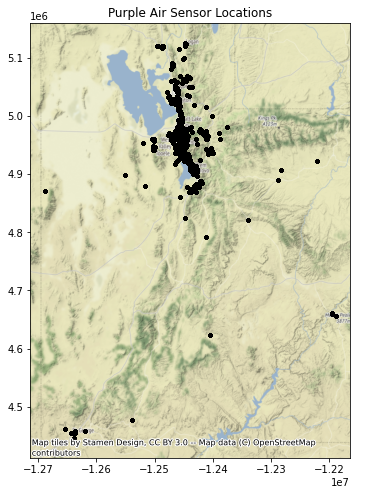

In [138]:
#Sensor Visualization
ut_leg_gdf = gpd.GeoDataFrame(ut_leg_df, geometry=gpd.points_from_xy(ut_leg_df.Lon,ut_leg_df.Lat))
ut_leg_gdf.crs = {'init' :'epsg:4326'}
ut_leg_gdf = ut_leg_gdf.to_crs({'init': 'epsg:3857'})

# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(16,8))

#plot the location
ut_leg_gdf.plot(ax = ax,color = 'k',markersize = 10,marker='o')
ax.set_title('Purple Air Sensor Locations')
#ax[1].set_xlim(-1.249e7, -1.242e7)
#ax[1].set_ylim(4910000, 4960000)
ctx.add_basemap(ax)

f.savefig('Purp_2020.jpg')

In [43]:
airnow_df.head()

,Latitude,Longitude,Time,Parameter,Concentration,Unit,Raw_Concentration,AQI,Category,Site_Name,Site_Agency,AQS_ID,FULL_AQS_ID
0,37.179000,-113.305200,2020-04-05 18:00:00-06:00,OZONE,45.0,PPB,42,1,Hurricane,Utah Department of Environmental Quality,490530007,840490530007,NaN
1,37.179000,-113.305200,2020-04-05 18:00:00-06:00,PM2.5,4.8,UG/M3,20,1,Hurricane,Utah Department of Environmental Quality,490530007,840490530007,NaN
2,37.198300,-113.150600,2020-04-05 18:00:00-06:00,OZONE,44.0,PPB,41,1,Zion NP,National Park Service,490530130,840490530130,NaN
3,37.747445,-113.055524,2020-04-05 18:00:00-06:00,OZONE,45.0,PPB,42,1,Enoch,Utah Department of Environmental Quality,490210005,840490210005,NaN
4,37.747445,-113.055524,2020-04-05 18:00:00-06:00,PM2.5,4.1,UG/M3,17,1,Enoch,Utah Department of Environmental Quality,490210005,840490210005,NaN


In [45]:
#How many sensors are registered:
print("There are {0} legacy sensors".format(len(ut_leg_df['ID'].drop_duplicates())))
print("There are {0} experimental sensors".format(len(ut_exp_df['ID'].drop_duplicates())))
print("There are {0} airnow (EPA) sensors".format(len(airnow_df['Category'].drop_duplicates())))

There are 1025 legacy sensors
There are 521 experimental sensors
There are 27 airnow (EPA) sensors


In [46]:
airnow_df['Category'].drop_duplicates()

0                      Hurricane
2                        Zion NP
3                          Enoch
5                           Erda
7                    Herriman #3
9                    Harrisville
10                     Rose Park
12                            NR
13                   Copper View
15                            BV
17                     Hawthorne
19                    Smithfield
20                        Lindon
22               Timpanogos Cave
23                  Spanish Fork
25                  Murphy Ridge
27                            P2
28                         Myton
29                      Roosvelt
31                    Whiterocks
32                Canyonlands NP
33                     Moxa Arch
35                         Ouray
36                     Vernal #4
38             James Town Mobile
41                       Redwash
42    Dinosaur National Monument
Name: Category, dtype: object

These numbers make sense as they match the totals given by the airnow website for sensors across Utah. 

In [56]:
#What are the total number of Nans within the data?
ut_exp_df.isna().sum().sort_values()

ID                0
version           0
CH                0
Adc               0
Flags             0
isOwner           0
Icon              0
Lon               0
Lat               0
Label             0
Type              0
count             0
Time              0
age               0
conf              0
p1               42
pm               42
pm_0             42
pm_1             42
pm_2             42
pm_3             42
pm_4             42
pm_5             42
pm_10            42
pm_6             42
pm1              42
p5               42
p4               42
p3               42
p2               42
p6               42
Pressure        378
Temperature     378
Humidity        378
Elevation       406
Voc            7154
Ozone1         7266
dtype: int64

In [57]:
ut_leg_df.isna().sum().sort_values()

mapVersion                              0
Hidden                                  0
Time                                    0
LastSeen                                0
Lon                                     0
Lat                                     0
THINGSPEAK_SECONDARY_ID_READ_KEY        0
isOwner                                 0
THINGSPEAK_SECONDARY_ID                 0
THINGSPEAK_PRIMARY_ID                   0
Label                                   0
ID                                      0
mapVersionString                        0
baseVersion                             0
THINGSPEAK_PRIMARY_ID_READ_KEY          0
AGE                                     0
Stats                                 812
PM2_5Value                            812
Type                                 7000
pressure                             7280
humidity                             7280
temp_f                               7280
ParentID                             7294
DEVICE_LOCATIONTYPE               

In [58]:
airnow_df.isna().sum().sort_values()

Latitude                0
Longitude               0
Time                    0
Parameter               0
Concentration           0
Unit                    0
Raw_Concentration       0
AQI                     0
Category                0
Site_Name               0
Site_Agency             0
AQS_ID                  0
FULL_AQS_ID          1803
dtype: int64

Conclusion: The airnow data is most complete. There is missing data fairly often in the purple air data, with no PM values being complete. 

# Graphics for Presentation:

#### Let's Look at the trend in 2019

In [47]:
sensor_number = airnow_2019_df['AQS_ID'].drop_duplicates()
print('There were a total of {0} Airflow Sensors in Utah in 2019'.format(sensor_number.shape[0]))

There were a total of 25 Airflow Sensors in Utah in 2019


/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


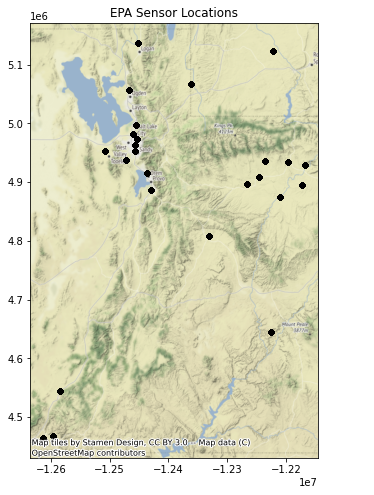

In [119]:
#Let's find out how many of these are in SLC
airnow_2019_gdf = gpd.GeoDataFrame(airnow_2019_df, geometry=gpd.points_from_xy(airnow_2019_df.Longitude,
                                                                               airnow_2019_df.Latitude))
airnow_2019_gdf.crs = {'init' :'epsg:4326'}
airnow_2019_gdf = airnow_2019_gdf.to_crs({'init': 'epsg:3857'})

# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(16,8))

#plot the location
airnow_2019_gdf.plot(ax = ax,color = 'k',markersize = 20,marker='o')
ax.set_title('EPA Sensor Locations')
#ax[1].set_xlim(-1.249e7, -1.242e7)
#ax[1].set_ylim(4910000, 4960000)
ctx.add_basemap(ax)

f.savefig('EPASensors2019.jpg')

In [74]:
#Calculate the daily averages per sensor

#Grab the PM2.5 Data 
airnow_2019_pm25 = airnow_2019_gdf[airnow_2019_gdf['Parameter']=='PM2.5']
airnow_2019_pm25['day'] = airnow_2019_pm25['Time'].apply(lambda x:x.day)
air_2019_avgd = pd.DataFrame(airnow_2019_pm25.groupby(['day','AQS_ID'])['Concentration'].mean()).reset_index()


/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


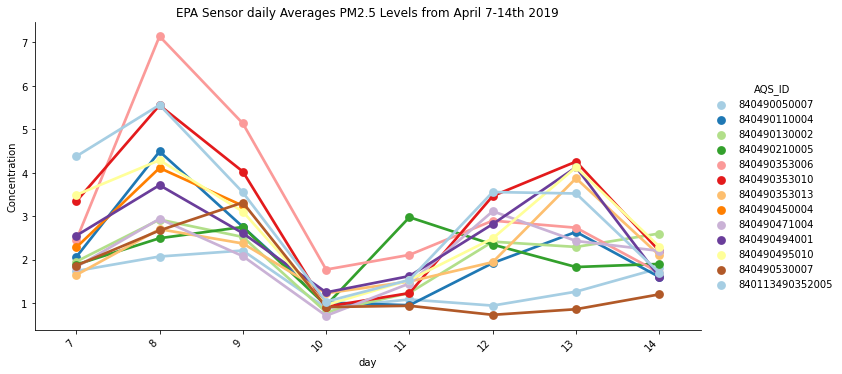

In [87]:
#Plot the sensors
air_2019 = sns.catplot(x='day',
                         y='Concentration',
                         hue='AQS_ID',
                         data=air_2019_avgd,
                         kind='point',
                         aspect=2,
                         palette = 'Paired')
air_2019.set_xticklabels(rotation = 45, ha="right")
air_2019.set(title = 'EPA Sensor daily Averages PM2.5 Levels from April 7-14th 2019')
air_2019.savefig('EPA_Airnow_2019.jpg')

In [80]:
#Perform a spatial join for the counties
counties =fiona.open('utah_counties.gdb')
counties.driver # OpenFileGDB
counties.schema # {'geometry': '3D MultiLineString', 'properties': OrderedDict([(u'FCSubtype', 'int'), ...
counties.crs # {'init': u'epsg:4326'}

# Build the GeoDataFrame from Fiona Collection
counties_gdf = gpd.GeoDataFrame.from_features([feature for feature in counties], crs=counties.crs)
# Get the order of the fields in the Fiona Collection; add geometry to the end
columns = list(counties.meta["schema"]["properties"]) + ["geometry"]
# Re-order columns in the correct order
counties_gdf = counties_gdf[columns]

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [91]:
#Try a spatial join:
air_count_19 = gpd.sjoin(airnow_2019_pm25, counties_gdf, op= 'within')
air_19_count_avgd = pd.DataFrame(air_count_19.groupby(['day','NAME'])['Concentration'].mean()).reset_index()

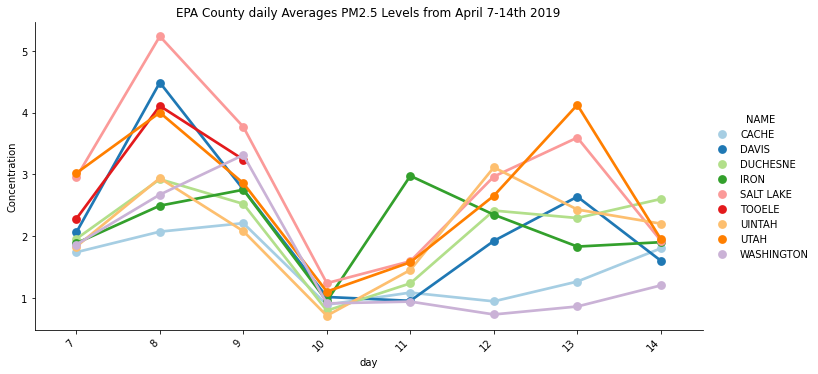

In [93]:
#Plot the sensors
air_count_2019 = sns.catplot(x='day',
                         y='Concentration',
                         hue='NAME',
                         data=air_19_count_avgd,
                         kind='point',
                         aspect=2,
                         palette = 'Paired')
air_count_2019.set_xticklabels(rotation = 45, ha="right")
air_count_2019.set(title = 'EPA County daily Averages PM2.5 Levels from April 7-14th 2019')
air_2019.savefig('EPA_Airnow_cou_ag_2019.jpg')

#### Let's Examine the trends in 2020

In [106]:
sensor_number = airnow_df['AQS_ID'].drop_duplicates()
print('There are a total of {0} Airflow Sensors in Utah in 2020'.format(sensor_number.shape[0]))

There are a total of 27 Airflow Sensors in Utah in 2020


/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


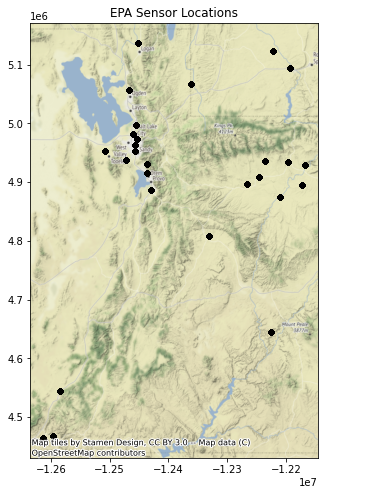

In [107]:
#Let's find out how many of these are in SLC
airnow_gdf = gpd.GeoDataFrame(airnow_df, geometry=gpd.points_from_xy(airnow_df.Longitude,
                                                                               airnow_df.Latitude))
airnow_gdf.crs = {'init' :'epsg:4326'}
airnow_gdf = airnow_gdf.to_crs({'init': 'epsg:3857'})

# Set up the plotting environment
f,ax = plt.subplots(1,1,figsize=(16,8))

#plot the location
airnow_gdf.plot(ax = ax,color = 'k',markersize = 20,marker='o')
ax.set_title('EPA Sensor Locations')
#ax[1].set_xlim(-1.249e7, -1.242e7)
#ax[1].set_ylim(4910000, 4960000)
ctx.add_basemap(ax)

f.savefig('EPASensors2020.jpg')

In [129]:
#Try a spatial join:
air_count_20 = gpd.sjoin(airnow_gdf, counties_gdf, op= 'within')

#Grab the PM2.5 Data 
airnow_2020_pm25 = air_count_20[air_count_20['Parameter']=='PM2.5']
airnow_2020_pm25['day'] = airnow_2020_pm25['Time'].apply(lambda x:x.day)

air_20_count_avgd = pd.DataFrame(airnow_2020_pm25.groupby(['day','NAME'])['Concentration'].mean()).reset_index()

/home/boogie2/anaconda3/envs/purp_air/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [124]:
airnow_2020_pm25.NAME.drop_duplicates()

1     WASHINGTON
4           IRON
6         TOOELE
8      SALT LAKE
16         DAVIS
21          UTAH
30      DUCHESNE
37        UINTAH
Name: NAME, dtype: object

In [123]:
air_count_20.NAME.drop_duplicates()

0     WASHINGTON
3           IRON
5         TOOELE
7      SALT LAKE
9          WEBER
15         DAVIS
19         CACHE
20          UTAH
27        CARBON
28      DUCHESNE
31        UINTAH
32      SAN JUAN
Name: NAME, dtype: object

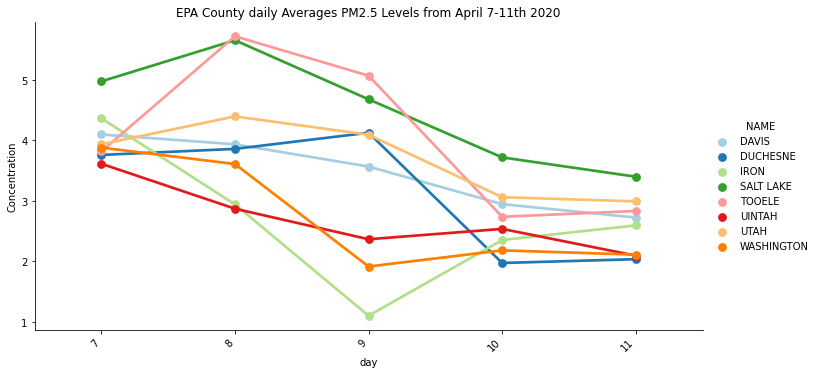

In [112]:
#Plot the sensors
air_count_2020 = sns.catplot(x='day',
                         y='Concentration',
                         hue='NAME',
                         data=air_20_count_avgd,
                         kind='point',
                         aspect=2,
                         palette = 'Paired')
air_count_2020.set_xticklabels(rotation = 45, ha="right")
air_count_2020.set(title = 'EPA County daily Averages PM2.5 Levels from April 7-11th 2020')
air_count_2020.savefig('EPA_Airnow_cou_ag_2020.jpg')